---
# Trabalho do Grau A - Grupo TA 09
##### Integrantes: Jhordan Pacheco, Filipe Martins Santos, Hedo Júnior, Gustavo Odriozola, Dione Adam
---
##### Inteligência Artificial e Aprendizado de Máquina (2023/1)
##### Problema selecionado: **Caixeiro-Viajante (TSP)**

O problema do caixeiro viajante descreve o desafio de descobrir o caminho mais breve que um vendedor viajante pode percorrer para passar por cada cidade exatamente uma vez, retornando ao ponto de partida. O problema é NP-difícil, o que denota que não há uma solução conhecida que possa resolvê-lo em tempo polinomial para todos os casos, tornando crucial o uso de algoritmos heurísticos ou aproximações para alcançar soluções satisfatórias. O problema tem aplicações em logística, transporte, roteamento e organização de viagens, dentre outros setores.

Modelagem. Definir a representação do problema escolhido (codificação, função objetivo, etc.) e analisar
o espaço de busca resultante (complexidade, tamanho da vizinhança, etc.).



*   Codificação: Para a população inicial, cada cromossomo consistirá em uma representação de permutação por meio de um vetor, que será uma sequência de visitação entre as cidades gerada de forma aleatória. Esse processo se repetirá até o surgimento de um individuo bem adaptado, ou a passagem de 100 gerações. A cada geração, os indíviduos serão dispostos a um processo de seleção, cruzamento e mutação, sendo utilizados dois operadores para cada um desses passos. A população iniciará com o mesmo número de cromossomos do que a quantidade de cidades disponíveis no problema.

*   Função de fitness: A função de fitness será o cálculo da distância média percorrida entre as cidades, para que haja um maior aproveitamento de cada solução, visto que utilizar o somatório das distâncias poderia desfavorecer soluções que começam bem e pioram no final.

*   Seleção: Os indivíduos serão selecionados por meio de torneio, feito utilizando dois grupos de 10% do total da população, selecionados aleatoriamente. De cada grupo é selecionado o melhor de acordo com a função de fitness.

*   Cruzamento: O cruzamento será feito utilizando Order Crossover, onde o filho adere uma parte ordenada do Pai 1 e o restante é aderido do Pai 2, na mesma ordem que constar. As cidades adquiridas do Pai 1 são puladas.

*   Mutação: Será considerada uma taxa de mutação de 2%.

* Tamanho de vizinhança: A vizinhança pode ser definida como todas as soluções que podem ser obtidas trocando duas cidades adjacentes na rota. 

* Complexidade: T(n) = O(N^2 * M), onde N é o tamanho da população e M é o número de gerações



## **Implementação**

O código apresentado define uma classe chamada Fitness que é utilizada para calcular a aptidão de uma rota em um problema de otimização de rotas. A classe possui dois métodos, "routeDistance" e "routeFitness", que calculam a distância total da rota e a aptidão da rota, respectivamente. 

In [22]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0

    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(len(self.route)):
                fromCity = self.route[i]
                toCity = self.route[(i + 1) % len(self.route)]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def routeFitness(self):
        if self.fitness == 0:
            total_distance = self.routeDistance()
            mean_distance = total_distance / len(self.route)
            self.fitness = 1 / mean_distance
        return self.fitness

---
A classe City possui métodos para calcular a distância entre duas cidades, obter as coordenadas X e Y da cidade, além de um método de representação em formato de string. A biblioteca NumPy é utilizada para calcular a distância entre as cidades.

In [23]:
import numpy as np

class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        return np.hypot(self.x - city.x, self.y - city.y)

    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"
    
    def getX(self):
        return self.x

    def getY(self):
        return self.y

---
A função "createRoute" recebe uma lista de cidades e retorna uma rota aleatória. Já a função "initialPopulation" recebe uma lista de cidades e cria uma população inicial de rotas aleatórias, com base no tamanho da lista de cidade.

In [24]:
import numpy as np, random, operator, pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files 
import io

import random



def createRoute(cityList):
    if not isinstance(cityList, list):
        raise TypeError("cityList deve ser uma lista")
    if len(cityList) < 1:
        raise ValueError("cityList não pode estar vazio")

    random.shuffle(cityList)

    return cityList

def initialPopulation(cityList):
    popSize = len(cityList)
    population = []
    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

---
A função "rankRoutes" recebe uma população e retorna um dicionário com o índice e a aptidão de cada rota, ordenada em ordem decrescente de aptidão. A função "selection" recebe uma lista de rotas ranqueadas e um eliteSize e retorna uma lista de índices dos indivíduos selecionados para reprodução.

In [25]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

---
A técnica de cruzamento Order Crossover (OX) cria novos indivíduos a partir de uma "pool de acasalamento" (mating pool) gerada pela técnica de seleção. O OX envolve a escolha aleatória de dois pontos de corte em um dos pais, e a criação de um filho que herda uma parte de cada pai, mantendo a ordem dos elementos herdados. A função orderCrossoverPopulation utiliza o OX para criar uma nova população a partir da "pool de acasalamento".

In [26]:
def matingPool(population, selectionResults):
    return [population[i] for i in selectionResults]

def orderCrossover(parent1, parent2):
    child = [-1] * len(parent1)

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        child[i] = parent1[i]

    idx = endGene
    for elem in parent2[endGene:] + parent2[:endGene]:
        if elem not in child:
            child[idx % len(parent1)] = elem
            idx += 1

    return child

def orderCrossoverPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])

    for i in range(0, length):
        child = orderCrossover(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children


---
A função mutate recebe um indivíduo (uma rota) e uma taxa de mutação e faz um swap aleatório entre dois genes (cidades) da rota. A função mutatePopulation itera sobre toda a população e aplica a função mutate a cada indivíduo, retornando uma nova população mutada.

In [27]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

---
A função geneticAlgorithm inicia a população, evolui as gerações e retorna a melhor rota encontrada. A função geneticAlgorithmPlot plota um gráfico da evolução da distância da melhor rota encontrada em cada geração. A função showMap plota as cidades do problema em um gráfico. A leitura do arquivo com as coordenadas das cidades é feita no final do código.

In [34]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = orderCrossoverPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)

    return nextGeneration

def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)

    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

def geneticAlgorithmPlot(population, eliteSize, mutationRate, generations):
    pop = initialPopulation(population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])

        plt.plot(progress)
        plt.ylabel('Distance')
        plt.xlabel('Generation')
    plt.show()

def showMap(population):
    x = []
    y = []
    for city in population:
        x.append(city.getX())
        y.append(city.getY())
        plt.plot(x, y, 'ro')
        plt.ylabel('Distance X')
        plt.xlabel('Distance Y')
    plt.show()

cityList = []

uploaded = files.upload()
filename = next(iter(uploaded.keys()))

with open(filename, 'r') as f:
        for line in f:
            line = line.split()
            cityList.append(City(x=int(line[1]), y=int(line[2])))



Saving st70.tsp.txt to st70.tsp.txt


---
Os parametros abaixo são utilizando a nossa solução para o problema. Após fazer a execução com eles podemos examinar que a taxa de mutação está com a porcentagem muito alta, dessa forma a qualidade dos resultados ficou abaixo do esperado.


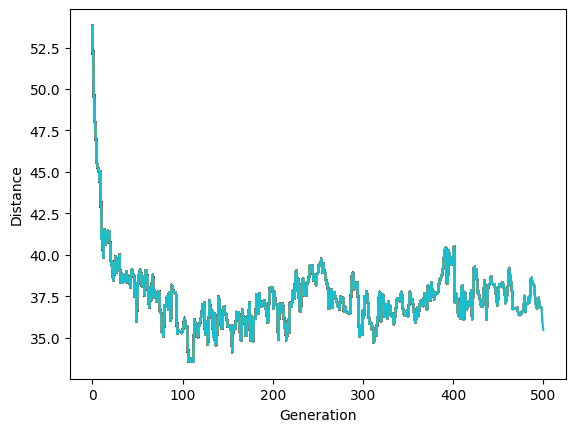

In [35]:
geneticAlgorithmPlot(population=cityList, eliteSize=10, mutationRate=0.02, generations=500)

---
Após fazer uma alteração na mutação alterando 2% para 0,2%, obtivemos um resultado bem melhor. Dessa forma podemos considerar que a taxa de mutação deve possuir um valor que evite a não progressão dos resultados, mas mesmo assim não perdendo a qualidade do mesmo.

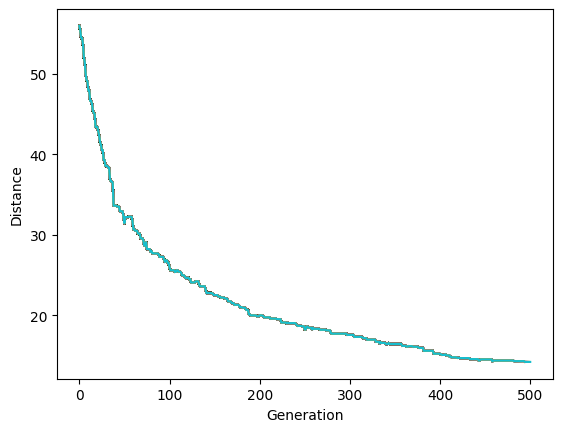

In [36]:
geneticAlgorithmPlot(population=cityList, eliteSize=10, mutationRate=0.002, generations=500)